## **Supplier Performance Evaluation Using Procurement KPIs**

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("Procurement KPI Analysis Dataset.csv")
data.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No


### **Basic preprocessing**

<b> Data cleaning


In [3]:
data.describe()

,Quantity,Unit_Price,Negotiated_Price,Defective_Units
count,777.000000,777.000000,777.000000,641.000000
mean,1094.660232,58.283822,53.660721,74.803432
std,647.844551,28.101315,26.094930,69.187870
min,51.000000,10.840000,9.270000,0.000000
25%,615.000000,33.290000,30.460000,26.000000
50%,1075.000000,58.950000,53.800000,49.000000
75%,1548.000000,83.130000,76.550000,100.000000
max,5000.000000,109.170000,107.390000,321.000000


During data preprocessing, it was observed that the order with ID 101 had a Delivery_Date (2022-02-27) that occurred earlier than its Order_Date (2022-02-22), indicating a likely data entry error. Since this issue was found in a single record, the order was removed from the dataset.

In [4]:
data.iloc[100,:]

PO_ID                      PO-00101
Supplier                  Alpha_Inc
Order_Date               2022-02-27
Delivery_Date            2022-02-22
Item_Category       Office Supplies
Order_Status              Delivered
Quantity                        211
Unit_Price                    75.69
Negotiated_Price               65.4
Defective_Units                 2.0
Compliance                      Yes
Name: 100, dtype: object

In [5]:
data = data.drop(100).reset_index(drop=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PO_ID             776 non-null    object 
 1   Supplier          776 non-null    object 
 2   Order_Date        776 non-null    object 
 3   Delivery_Date     689 non-null    object 
 4   Item_Category     776 non-null    object 
 5   Order_Status      776 non-null    object 
 6   Quantity          776 non-null    int64  
 7   Unit_Price        776 non-null    float64
 8   Negotiated_Price  776 non-null    float64
 9   Defective_Units   640 non-null    float64
 10  Compliance        776 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 66.8+ KB


As it can be seen from the data info, Order_Date and Delivery_Date are object type columns, so these columns will be converted to datetime type for the further analysis.

In [7]:
data['Order_Date'] = pd.to_datetime(data['Order_Date'])
data['Delivery_Date'] = pd.to_datetime(data['Delivery_Date'])

In [8]:
data.drop("PO_ID", inplace=True, axis = 1)

<b>Missing values analysis and imputation

In [9]:
data.isnull().sum()

Supplier              0
Order_Date            0
Delivery_Date        87
Item_Category         0
Order_Status          0
Quantity              0
Unit_Price            0
Negotiated_Price      0
Defective_Units     136
Compliance            0
dtype: int64

Missing values are present in two columns, Delivery_Date and Defective_Units with total od 87 and 136 missing values, respectively.

<AxesSubplot: >

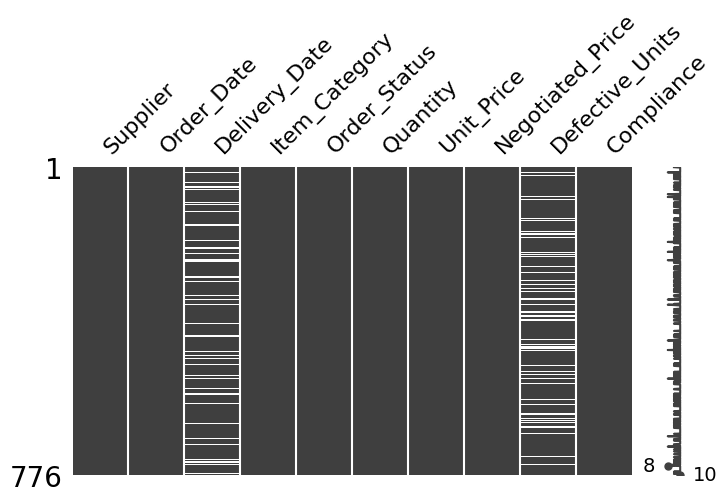

In [10]:
msno.matrix(data, figsize=(8,4))

**Defective Units missing data imputation using KNNImputer**

For imputation of missing data in Defective_Units column, KNN imputer is used. KNNImputer uses mean value from the K-nearest neighbors. K value in this case is set to 10.
<br>For the imputation we used only numeric columns Quantity, Unit_Price, Negotiated_Price, Defective_Units and normalize them between 0 and 1 using MinMaxScaler. Since KNNImputer is a distance-based algorithm scaling is an important step in pipeline.

In [11]:
# subset of the dataset
data_knn = data.filter(['Quantity', 'Unit_Price', 'Negotiated_Price', 'Defective_Units'], axis=1).copy()

# scale data to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_knn = pd.DataFrame(scaler.fit_transform(data_knn), columns = data_knn.columns)

# define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
data_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_knn), columns=data_knn.columns)

data_knn_imputed

,Quantity,Unit_Price,Negotiated_Price,Defective_Units
0,0.227319,0.094478,0.087036,0.199065
1,0.294605,0.289637,0.286078,0.732087
2,0.173570,0.861080,0.845801,0.127726
3,0.261265,0.905217,0.879026,0.348910
4,0.228127,0.541340,0.522422,0.532710
...,...,...,...,...
771,0.330168,0.331333,0.336017,0.816199
772,0.079612,0.590867,0.520587,0.021807
773,0.089513,0.854063,0.740114,0.090343
774,0.253587,0.103834,0.091724,0.398754


Next step was to unstandardize the imputed data and fill missing values in original data set.

In [12]:
# unstandardize the data
data_knn_unscaled = pd.DataFrame(scaler.inverse_transform(data_knn_imputed), columns=data_knn.columns)
data_knn_unscaled.head(5)

,Quantity,Unit_Price,Negotiated_Price,Defective_Units
0,1176.0,20.13,17.81,63.9
1,1509.0,39.32,37.34,235.0
2,910.0,95.51,92.26,41.0
3,1344.0,99.85,95.52,112.0
4,1180.0,64.07,60.53,171.0


In [13]:
data['Defective_Units'] = data['Defective_Units'].fillna(data_knn_unscaled['Defective_Units'])
data['Defective_Units'] = data['Defective_Units'].astype('int')
data['Defective_Units'].head(3)

0     63
1    235
2     41
Name: Defective_Units, dtype: int32

**Delivery Date missing data imputation using mean value**

To fill missing values in the Delivery_Date column, a new column called Delivery_Days was created. This column represents the number of days needed to deliver an order and was calculated based on the available Order_Date and Delivery_Date data. The mean delivery time was found to be approximately 10.8 days, which was rounded up to 11 days since the dataset only contains date information (no time). Missing Delivery_Date values were then filled by adding this rounded average delivery time to the corresponding Order_Date.

In [14]:
data['Delivery_Days'] = (data['Delivery_Date'] - data['Order_Date']).dt.days
avg_delivery = data['Delivery_Days'].mean()

avg_delivery_rounded = int(np.ceil(avg_delivery)) # round it to get discrete number of days
print(avg_delivery)

data.loc[data['Delivery_Date'].isna(), 'Delivery_Date'] = (data['Order_Date'] + pd.to_timedelta(avg_delivery_rounded, unit='days'))
data['Delivery_Days'] = (data['Delivery_Date'] - data['Order_Date']).dt.days

10.799709724238026


In [15]:
data[['Order_Date','Delivery_Date']].head()

,Order_Date,Delivery_Date
0,2023-10-17,2023-10-25
1,2022-04-25,2022-05-05
2,2022-01-26,2022-02-15
3,2022-10-09,2022-10-28
4,2022-09-08,2022-09-20


In [16]:
data.isnull().sum().sum()

0

All missing values are filled

#### **Exploratory Data Analysis (EDA)**

**Correlation matrix** - it is expected to see a almost perfect postive correlation (0.99) between unit price and negotiated price since the negotiated price is derived from the unit price through agreed discounts. Beacuse these two features are highly correlated it can consider to exclude one during modeling. Also there is a moderate positive correlation (0.48) between quantity and defective units, which is expected since larger order quantities naturally increase the likelihood of having more defective units.

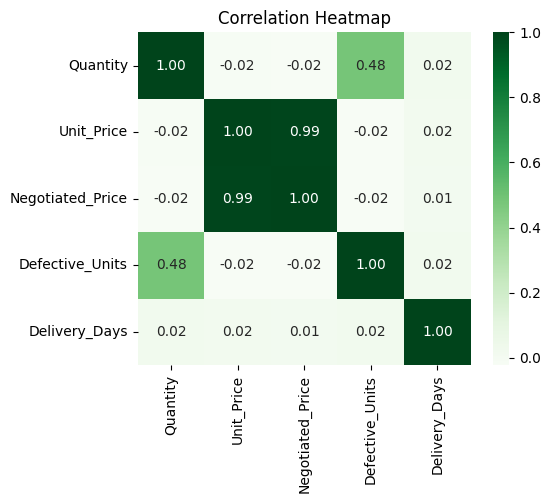

In [17]:
corr = data.corr(numeric_only=True)

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Greens", square=True)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

**Analysis of Item Categories per Supplier**

In [18]:
item_categories = data.groupby(['Supplier', 'Item_Category']).size().reset_index(name='Count')
item_categories

,Supplier,Item_Category,Count
0,Alpha_Inc,Electronics,22
1,Alpha_Inc,MRO,35
2,Alpha_Inc,Office Supplies,38
3,Alpha_Inc,Packaging,27
4,Alpha_Inc,Raw Materials,18
5,Beta_Supplies,Electronics,32
6,Beta_Supplies,MRO,26
7,Beta_Supplies,Office Supplies,41
8,Beta_Supplies,Packaging,30
9,Beta_Supplies,Raw Materials,27


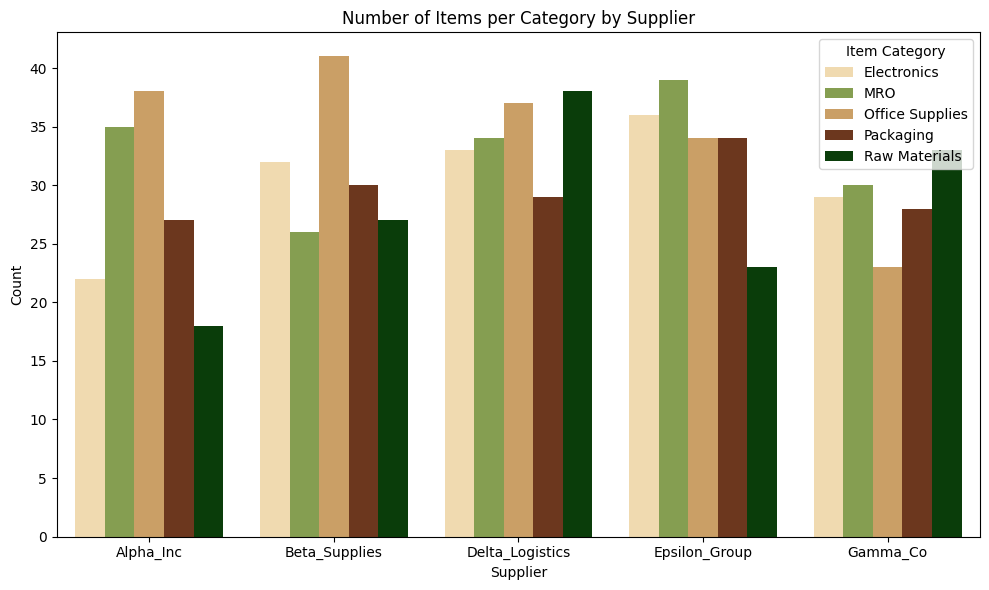

In [19]:
plt.figure(figsize=(10,6))
custom_palette = ["#fbdda5",  "#89AB44", "#dba155", "#793211", "#024502"]

sns.barplot(data=item_categories, x='Supplier', y='Count', hue='Item_Category', palette=custom_palette)
plt.title('Number of Items per Category by Supplier')
plt.ylabel('Count')
plt.legend(title='Item Category')
plt.tight_layout()
plt.show()

As shown in the graph, Alpha Inc. and Beta Supplies primarily deliver Office Supplies, Delta Logistics and Gamma Co. focus on Raw Materials, while Epsilon Group mainly delivers MRO Supplies.

**Analysis of Order Status**

In [20]:
delivered_orders = data.groupby('Order_Status').size().reset_index(name="Count")
delivered_orders['Percentage'] = delivered_orders['Count'].apply(lambda x: round(x/ delivered_orders['Count'].sum() *100,2))
delivered_orders


,Order_Status,Count,Percentage
0,Cancelled,63,8.12
1,Delivered,559,72.04
2,Partially Delivered,73,9.41
3,Pending,81,10.44


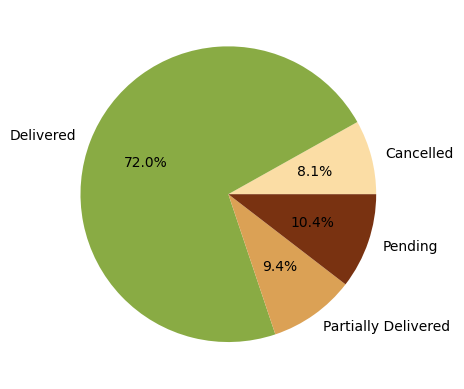

In [21]:
plt.pie(delivered_orders['Percentage'], labels=delivered_orders['Order_Status'], colors=custom_palette, autopct='%1.1f%%')
plt.show()

The pie chart shows that the majority of orders (72%) are delivered by the supplier, while the remaining 28% are distributed among other order statuses Cancelled (8.1%), Pending (10.4%), and Partially Delivered (9.4%)

**Monthly Order Quantities per Supplier**

In [22]:
data['Month'] = data['Order_Date'].dt.to_period('M')
monthly = data.groupby(['Supplier', 'Month'])['Quantity'].sum().reset_index()

monthly['Month_TS'] = monthly['Month'].dt.to_timestamp()
monthly.head()

,Supplier,Month,Quantity,Month_TS
0,Alpha_Inc,2022-01,6560,2022-01-01
1,Alpha_Inc,2022-02,5790,2022-02-01
2,Alpha_Inc,2022-03,3469,2022-03-01
3,Alpha_Inc,2022-04,5541,2022-04-01
4,Alpha_Inc,2022-05,4046,2022-05-01


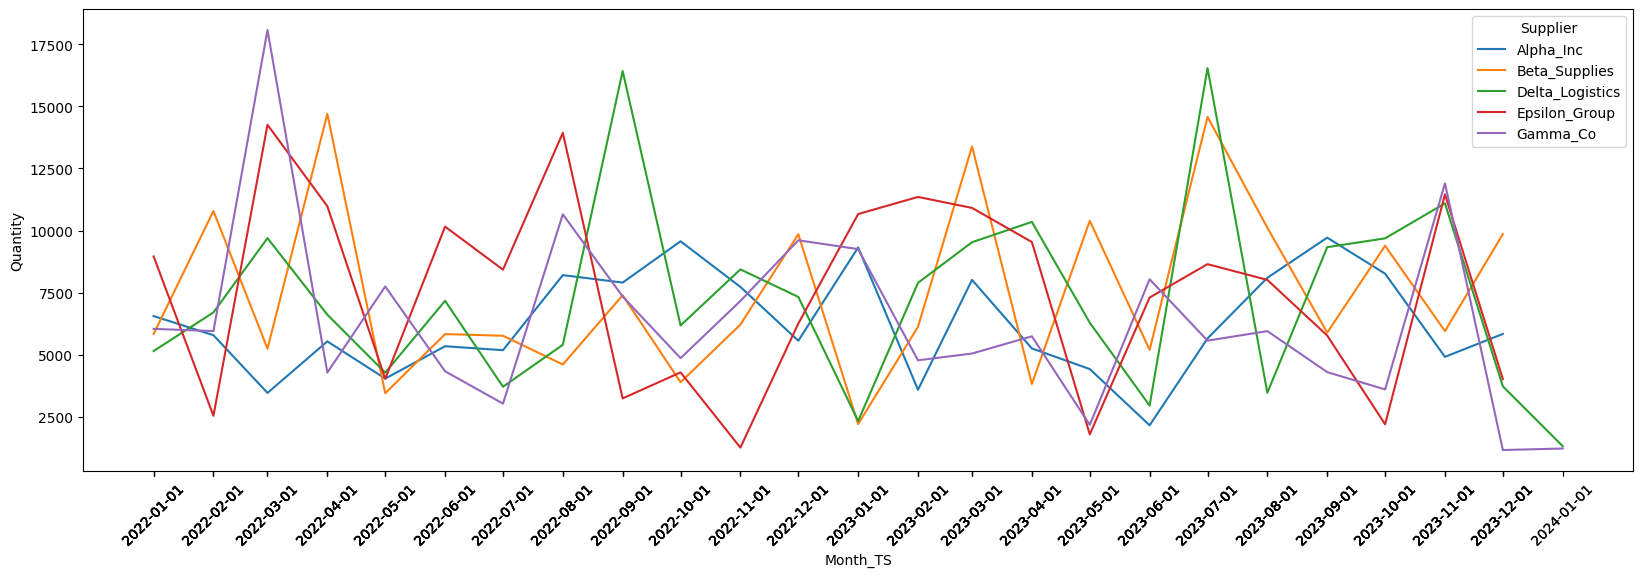

In [23]:
plt.figure(figsize=(20,6))
sns.lineplot(monthly, x='Month_TS', y='Quantity', hue="Supplier")
plt.xticks(monthly['Month_TS'].values, rotation=45)

plt.show()

Alpha_Inc shows low but steady monthly quantities, indicating consistent small-scale orders. Beta_Supplies has moderate volumes with a few noticeable peaks, suggesting periodic increases in demand. Delta_Logistics handles the highest and most stable quantities overall, making it the primary high-volume supplier. Epsilon_Group displays sharp ups and downs, showing inconsistent ordering patterns. Gamma_Co also fluctuates significantly, with some very high peaks and very low months, reflecting irregular or specialized procurement.

#### **Procurement KPIs Analysis**

In [24]:
kpi_summary = pd.DataFrame()

**Defective Rate(%)**

Defective rate(%): the percentage of defective items out of the total number of items received.

In [25]:
total_defects = data.groupby('Supplier')[['Defective_Units', 'Quantity']].sum().reset_index()
total_defects['Defective_Rate(%)'] = (total_defects['Defective_Units']/total_defects['Quantity']).apply(lambda x: x*100).round(2)
kpi_summary['Supplier'] = total_defects['Supplier']
kpi_summary['Defective_Rate(%)'] = total_defects['Defective_Rate(%)']
total_defects

,Supplier,Defective_Units,Quantity,Defective_Rate(%)
0,Alpha_Inc,4786,150203,3.19
1,Beta_Supplies,15750,180516,8.72
2,Delta_Logistics,22663,181652,12.48
3,Epsilon_Group,6290,180053,3.49
4,Gamma_Co,8225,157916,5.21


In [26]:
def bar_plot(data, y, title, y_label):  
    plt.figure(figsize=(6,4))
    sns.barplot(data=data, x="Supplier", y=y, color="seagreen", errorbar=None, width=0.5)
    plt.title(title, fontsize=14)
    plt.xlabel("Supplier")
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.xticks(total_defects['Supplier'], rotation=45)
    plt.show()

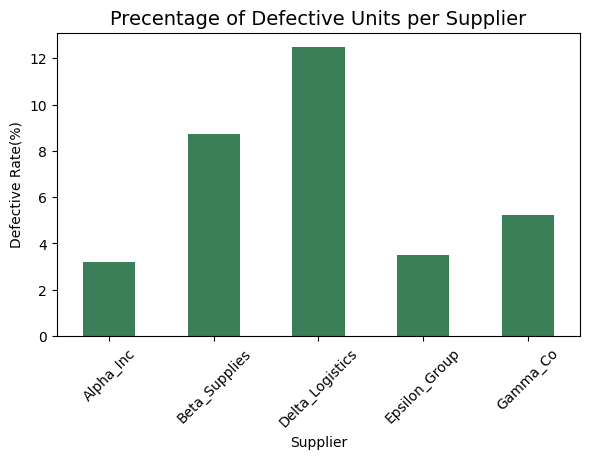

In [27]:
bar_plot(total_defects, 'Defective_Rate(%)', "Precentage of Defective Units per Supplier", "Defective Rate(%)")

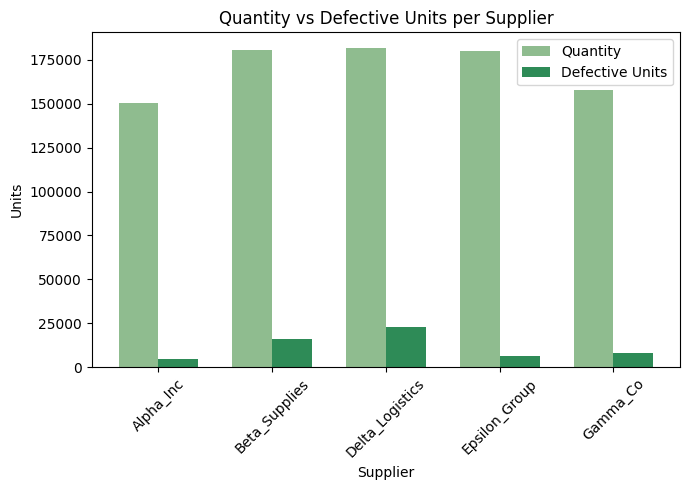

In [28]:
plt.figure(figsize=(7,5))

x = range(len(total_defects))
width=0.35

plt.bar([i - width/2 for i in x], total_defects['Quantity'], width=width, label='Quantity', color='darkseagreen')
plt.bar([i + width/2 for i in x], total_defects['Defective_Units'], width=width, label='Defective Units', color='seagreen')

plt.xticks(x, total_defects['Supplier'], rotation=45)
plt.xlabel("Supplier")
plt.ylabel("Units")
plt.title("Quantity vs Defective Units per Supplier")
plt.legend()
plt.tight_layout()
plt.show()

Analysis shows that the supplier with the highest defective rate, 12.5%, is <b>Delta Logistics</b>, which also delivered the highest total quantity of units (181,652). However, <b>Beta Supplies</b> and <b>Epsilon Group</b> delivered almost the same total number of units, but with noticeably lower defective rates of 8.7% and 3.5%, respectively. <b>Alpha Inc</b> recorded the lowest defective rate among all suppliers, with only 3.2% of its units classified as defective.

<b>On-time Delivery Rate(%)

On-time Delivery Rate(%): the percentage of orders delivered on or before the expected delivery date.

Since expected delivery date is not specified, on-time delivery is evaluated using two weeks or 14 days lead-time treshold.

In [29]:
data['On-time_Delivery'] = data['Delivery_Days'] < 14
#data['On-time_Delivery'] = data['On-time_Delivery'].replace({False: 'Late delivery', True:'On-time delivery'})
data['On-time_Delivery']

0       True
1       True
2      False
3      False
4       True
       ...  
771     True
772     True
773    False
774     True
775     True
Name: On-time_Delivery, Length: 776, dtype: bool

In [30]:
on_time_delivery = data.groupby('Supplier')['On-time_Delivery'].mean().apply(lambda x: x*100).round(2).reset_index(name='On_time_Delivery(%)')
kpi_summary['On_time_Delivery(%)'] = on_time_delivery['On_time_Delivery(%)']
on_time_delivery

,Supplier,On_time_Delivery(%)
0,Alpha_Inc,72.14
1,Beta_Supplies,60.26
2,Delta_Logistics,67.84
3,Epsilon_Group,66.87
4,Gamma_Co,72.03


Alpha Inc. and Gamma Co. achived the highest on-time delivery rate with 72.14% and 72.03% of orders delivered on time, respectively, while Beta Supplies recorded the lowest rate at 60.26%.

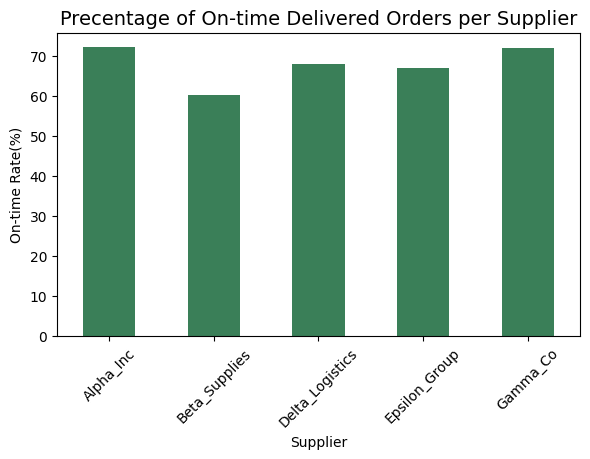

In [31]:
bar_plot(on_time_delivery, "On_time_Delivery(%)", "Precentage of On-time Delivered Orders per Supplier", "On-time Rate(%)")

<b>Average Lead Time

Average Lead Time: the average number of days between placing an order and receiving the goods.

In [32]:
average_lead_time = data.groupby('Supplier')['Delivery_Days'].mean().round(2).reset_index(name="Avg_Lead_Time")
kpi_summary['Avg_Lead_Time'] = average_lead_time['Avg_Lead_Time']
average_lead_time

,Supplier,Avg_Lead_Time
0,Alpha_Inc,10.79
1,Beta_Supplies,11.25
2,Delta_Logistics,10.87
3,Epsilon_Group,10.88
4,Gamma_Co,10.27


Average Lead time for all suppilers is similar around 10-11 days with Gamma Co having the shortest of 10.27 days and Beta Supplies the highest at 11.25 days.


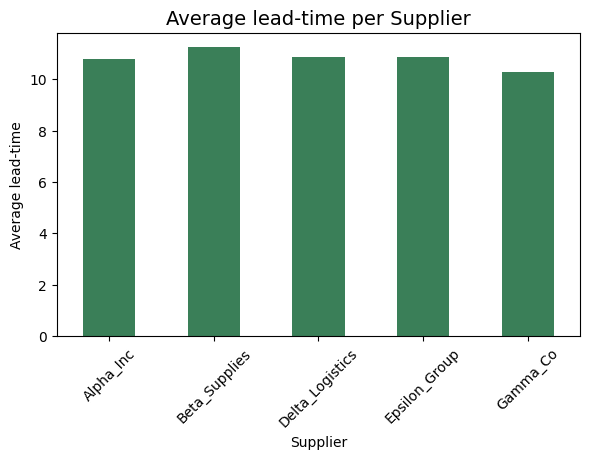

In [33]:
bar_plot(average_lead_time, 'Avg_Lead_Time', 'Average lead-time per Supplier', 'Average lead-time')

<b>Compliance Rate %

Compliance Rate (%): the percentage of supplier transactions that meet contractual, quality and delivery requirements.

In [34]:
data["Compliance"] = data['Compliance'].replace({"Yes": True, "No":False })

compilance_rate = data.groupby("Supplier")["Compliance"].mean().apply(lambda x: x*100).round(2).reset_index(name="Compilance_Rate(%)")
kpi_summary['Compilance_Rate(%)'] = compilance_rate['Compilance_Rate(%)']
compilance_rate

C:\Users\user\AppData\Local\Temp\ipykernel_15340\121946557.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Compliance"] = data['Compliance'].replace({"Yes": True, "No":False })


,Supplier,Compilance_Rate(%)
0,Alpha_Inc,93.57
1,Beta_Supplies,75.64
2,Delta_Logistics,60.82
3,Epsilon_Group,98.19
4,Gamma_Co,86.01


The compliance rate analysis shows that Epsilon Group achives a high level of compliance, with 98.19% of its orders meeting all contracual, quality and delivery requirements, while Delta Logistics shows the lowest performance, with only 60.82% of its orders meeting these requirements.

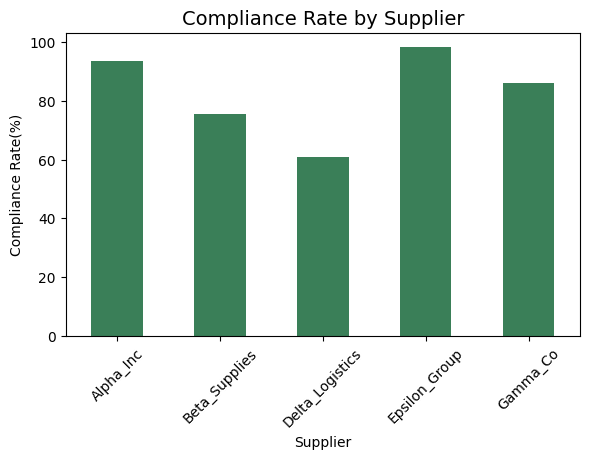

In [35]:
bar_plot(compilance_rate, 'Compilance_Rate(%)', "Compliance Rate by Supplier", 'Compliance Rate(%)')

<b>Fill Rate (%)

Fill Rate (%) shows how much customer demand is met with non-defective products.

In [36]:
data['Non_Defective_Units'] = data['Quantity'] - data['Defective_Units']
fill_rate = data.groupby("Supplier")['Non_Defective_Units'].sum().reset_index(name="Total_Non_Defective_Units")
fill_rate['Fill_Rate(%)'] = round((fill_rate['Total_Non_Defective_Units'] / total_defects['Quantity'])*100, 2)
kpi_summary['Fill_Rate(%)']= fill_rate['Fill_Rate(%)']
fill_rate

,Supplier,Total_Non_Defective_Units,Fill_Rate(%)
0,Alpha_Inc,145417,96.81
1,Beta_Supplies,164766,91.28
2,Delta_Logistics,158989,87.52
3,Epsilon_Group,173763,96.51
4,Gamma_Co,149691,94.79


Fill rate analysis shows that Epsilon Group achives the highest preformance with 96.51% of customer demandfulfilled without defective products, while Delta Logistics has the lowest fill rate at 87.52%.

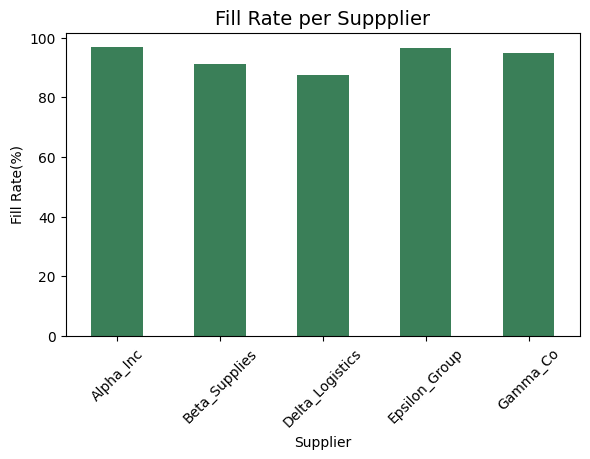

In [37]:
bar_plot(fill_rate, 'Fill_Rate(%)', 'Fill Rate per Suppplier', 'Fill Rate(%)')

**Cost Savings**

Cost Savings by Supplier represents the amount of money the company saves by purchasing items from a supplier at a negotiated price lower than the standard unit price. It shows how much financial benefit the company gains from each supplier based on price reductions.

In [38]:
data['Cost_Savings'] = (data['Unit_Price'] - data['Negotiated_Price']) * data['Quantity']

supplier_price_stats = data.groupby('Supplier').agg(
    Total_Actual_Spend = ('Unit_Price', lambda x: ((data.loc[x.index, 'Unit_Price'] * data.loc[x.index, 'Quantity']).sum().round(2))),
    Total_Negotiated_Spend = ('Negotiated_Price', lambda x: ((data.loc[x.index, 'Negotiated_Price'] * data.loc[x.index, 'Quantity']).sum()).round(2)),
    Total_Savings = ('Cost_Savings', 'sum')
).reset_index()


supplier_price_stats['Savings_(%)'] = ((supplier_price_stats['Total_Savings'] / supplier_price_stats['Total_Actual_Spend']) * 100).round(2)
kpi_summary['Savings_(%)'] = supplier_price_stats['Savings_(%)']
supplier_price_stats

,Supplier,Total_Actual_Spend,Total_Negotiated_Spend,Total_Savings,Savings_(%)
0,Alpha_Inc,8512662.15,7825912.85,686749.30,8.07
1,Beta_Supplies,10748606.79,9858665.90,889940.89,8.28
2,Delta_Logistics,10018216.96,9236240.47,781976.49,7.81
3,Epsilon_Group,10696136.24,9851156.06,844980.18,7.90
4,Gamma_Co,9313230.13,8587921.71,725308.42,7.79


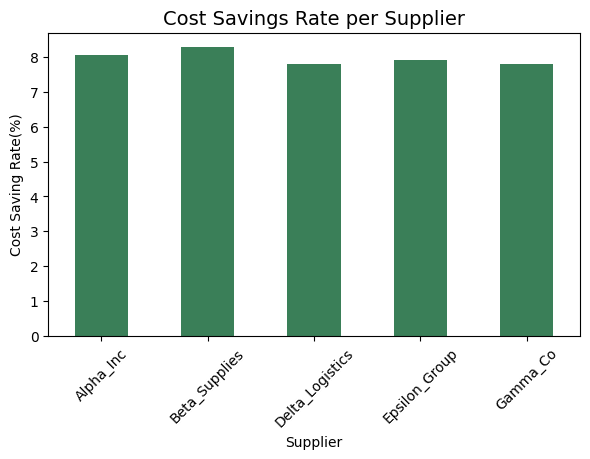

In [39]:
bar_plot(supplier_price_stats, 'Savings_(%)', 'Cost Savings Rate per Supplier', 'Cost Saving Rate(%)')

The chart shows that all suppliers achieve a similar cost-saving rate, ranging between 7.8% and 8.3%. Beta_Supplies leads slightly with the highest savings, while Delta_Logistics and Gamma_Co have the lowest but still comparable results. Overall, the small differences between suppliers indicate a consistent and balanced cost-optimization performance across the procurement process.

In [40]:
kpi_summary

,Supplier,Defective_Rate(%),On_time_Delivery(%),Avg_Lead_Time,Compilance_Rate(%),Fill_Rate(%),Savings_(%)
0,Alpha_Inc,3.19,72.14,10.79,93.57,96.81,8.07
1,Beta_Supplies,8.72,60.26,11.25,75.64,91.28,8.28
2,Delta_Logistics,12.48,67.84,10.87,60.82,87.52,7.81
3,Epsilon_Group,3.49,66.87,10.88,98.19,96.51,7.90
4,Gamma_Co,5.21,72.03,10.27,86.01,94.79,7.79


Across all suppliers, performance varies significantly depending on the KPI. Alpha_Inc shows one of the lowest defect rates and strong on-time delivery, making it a reliable and consistent supplier. Beta_Supplies has the highest cost savings but struggles with on-time delivery and has a relatively high defect rate. Delta_Logistics shows the weakest performance overall, with the highest defect rate, lowest compliance, and lowest fill rate, indicating frequent operational issues. Epsilon_Group performs strongly in compliance and keeps defect rates low, although its on-time delivery rate is mid-range. Gamma_Co maintains a balanced profile, with high on-time delivery, moderate defect rates, and strong compliance and fill rates. Overall, Alpha_Inc and Epsilon_Group stand out as the most reliable, while Delta_Logistics requires the most improvement across multiple KPIs.